### 敵対的生成ネットワーク（GAN）

GANの直感的理解は以下のよう。<br>
<ul>
    <li>ピカソの贋作を売ろうとしている人がいる。最初はあまり出来がよくない。</li>
    <li>美術商はどれが本物で、どれが贋作かを伝える。</li>
    <li>贋作画家はアトリエに戻り、再び贋作の製作に取り掛かる。</li>
    <li>やがて、贋作画家はピカソの画風を再現できるほど腕を上げ、美術商は贋作を見破る達人になっている。</li>
</ul>
これがGANの仕組みである。

贋作画家のネットワークと鑑定家のネットワークは、それぞれ相手を打ち負かすように出来ている。<br>

<ul>
    <li>生成者ネットワーク : 入力としてランダムベクトル（潜在空間のランダムな点）を受け取り、合成画像としてデコード。</li>
    <li>敵対者ネットワーク : 入力として画像（本物 or 偽物）を受け取り、その画像が訓練データセットから抽出されたものか、<br>
                               それとも生成者ネットワークによって生成されたものかを推測。</li>
</ul>

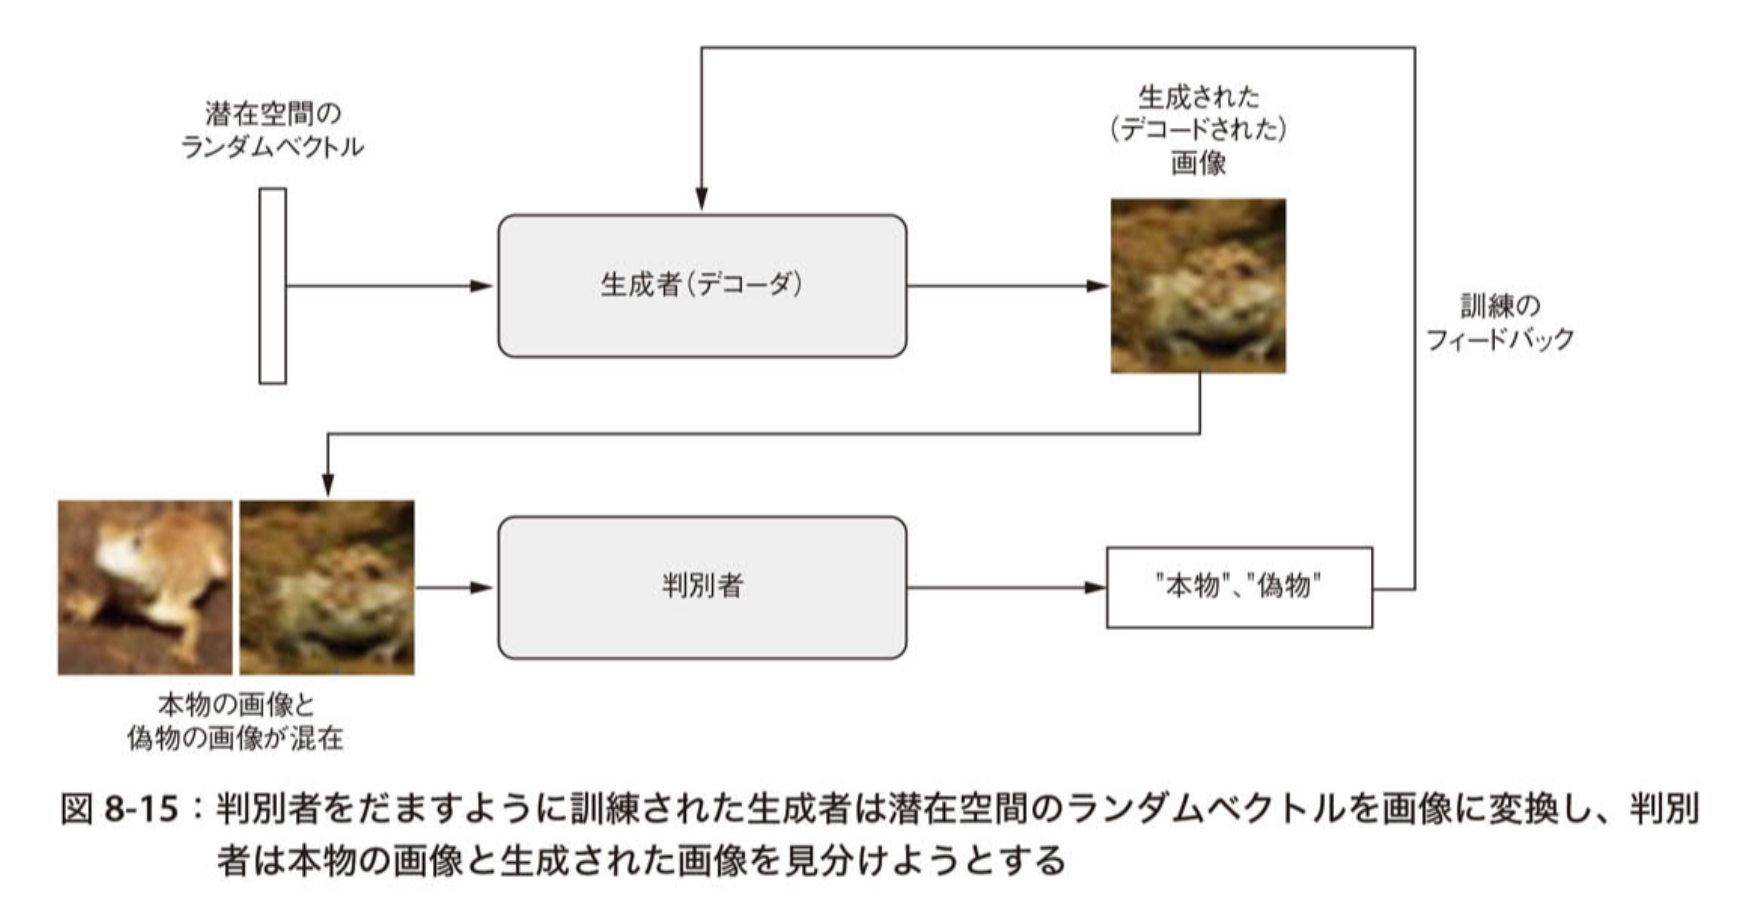

In [1]:
# 画像の表示
from IPython.display import Image
Image(filename='IMG/02.png', width=700)

特筆すべきところは、GANが「最適化の最小値が固定ではない」というところに存在する。<br>
通常、勾配降下法は損失関数の静的な地形にある丘を転がっていく。<br>
しかしGANでは、この丘をくだるごとに地形全体が小さくなる。<br>

GANは動的なシステムであり、最適化プロセスは最小値を探し求めるのではなく、２つの勢力を釣り合わせようとする。<br>
したがって、GANの訓練は難しいことで知られている。<br>

### 敵対的生成ネットワークの実装の概要

DCGANは、生成者と判別者がディープ畳み込みニューラルネットワークであるGAN。<br>

ここではCIFAR10の「カエル」クラスに属している画像を使用。<br>

GANの大まかな実装手順は以下のよう。<br>
<ol>
    <li>生成者ネットワークにより、形状が（latent_dim, ）のベクトルを形状が(32, 32, 3)の画像にマッピング。</li>
    <li>判別者ネットワークにより、形状が(32, 32, 3)の画像を２値のスコアにマッピング。
    このスコアは、その画像が本物か偽物かを推定する。</li>
    <li>GANネットワークにより、生成者と判別者をつなぎ合わせる。<br>
    このGANネットワークは、潜在空間のベクトルを、生成者によってデコードされたそれらの本物らしさに関する、<br>
    判別者の鑑定にマッピングする。</li>
    <li>本物と偽物の画像、および「real」ラベルと「fake」ラベルを使って判別者を訓練する。</li>
    <li>ステップごとに、生成者によってデコードされた画像を判別者が「本物」として分類する、<br>
         可能性が高くなる方向へ生成者の重みを移動する。</li>
</ol>

### 生成者ネットワーク

GANでよく見られる問題の一つとして、生成者がノイズのように見える画像を生成すること。<br>
解決策としてドロップアウトを使用することが上げられる。<br>

In [5]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim, ))
# print(generator_input.shape)

# 入力を16×16, 128チャネルの特徴マップに変換
x = layers.Dense(128 * 16 * 16)(generator_input)
# print(x.shape)
x = layers.LeakyReLU()(x)
# print(x.shape)
x = layers.Reshape((16, 16, 128))(x)
# print(x.shape)

# 畳み込み層を追加
x = layers.Conv2D(256, 5, padding='same')(x) 
# print(x.shape)
x = layers.LeakyReLU()(x)

# 32×32にアップサンプリング
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
# print(x.shape)
x = layers.LeakyReLU()(x)
# print(x.shape)

# さらに畳み込み層を追加
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
# print(x.shape)
# 32×32、１チャネル(CIFAR10の画像の形状)の特徴マップを生成
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

# generatorモデルをインスタンス化
# 形状が(latent_dim, )の入力を形状が(32, 32, 3)の画像にマッピング
generator = keras.models.Model(generator_input, x)
generator.summary()

(?, ?, ?, 3)
(?, ?, ?, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 256)  

### 判別者ネットワーク

このモデルは入力として渡された候補画像を、<br>
「生成された画像」クラスと「訓練データセットから抽出された本物の画像」クラスのどちらかに分類する。<br>

In [10]:
## GANの判別者ネットワーク
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# ドロップアウト層を一つ追加 : 重要なトリック
x = layers.Dropout(0.4)(x)

# 分類層
x = layers.Dense(1, activation='sigmoid')(x)

# discriminatorモデルをインスタンス化
# 形状が(32, 32, 3)の入力で二値分類(fake/real)を実行
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# オプティマイザで勾配刈込みを使用し(cultivate)、
# 訓練を安定させるために学習率減衰を使用(decay)
discriminator_optomizer = keras.optimizers.RMSprop(lr=0.0008,
                                                  clipvalue=1.0,
                                                  decay=1e-8)
discriminator.compile(optimizer=discriminator_optomizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

### 敵対者ネットワーク

最後に、生成者と判別者をつなぎ合わせるganモデルを定義する。<br>
このモデルを訓練すると、判別者を騙す能力が向上する方向に生成者が移動する。<br>
discriminatorが偽物の画像を見たときに「本物」と予測する可能性が高くなるように、<br>
generatorの重みが更新される。<br>
ここで、ganの訓練中にdiscriminatorの重みが更新されることはない。<br>
discriminatorの重みを更新できるとしたら、常に「本物」と予測するようにdiscriminatorを訓練することになる。<br>

In [12]:
# discriminatorの重みを訓練不可能に設定(これはganモデルのみに適用される)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)

gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### DCGANの訓練方法

エポックごとに以下の手順を繰り返す。<br>
<ol>
    <li>潜在空間から点をランダムに抽出。</li>
    <li>このランダムノイズを使ってgeneratorで画像を生成。</li>
    <li>生成された画像を本物の画像に混ぜる。</li>
    <li>これらの画像と対応する目的値（ラベル）を使って、discriminatorを訓練。<br>
    目的値は「real」（本物の画像）または「fake」（生成された画像）</li>
    <li>潜在空間から新しい点をランダムに抽出。</li>
    <li>これらのランダムベクトルと目的値を使ってganを訓練する。<br>
    目的値はどれも「これらが本物の画像である」ことを表している。<br>
    これにより、生成された画像をdiscriminatorが「本物の画像」と予測するようにgeneratorの重みが更新される。<br>
    discriminatorはgan内部で凍結されるため、更新されるのはgeneratorの重みだけである。<br>
    このようにして、generatorはdiscriminatorを騙すように訓練される。<br>
    </li>
</ol>